In [ ]:
!pip3 install numpy==1.22.1 matplotlib==3.8 opencv-python gtsam tqdm open3d

In [ ]:
!pip install typeguard

In [101]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import gtsam
import glob
import open3d as o3d
from tqdm import tqdm

In [102]:
# # KITTI
# fx, fy = 718.856, 718.856
# cx, cy = 607.1928, 185.2157

# TUM
fx, fy, cx, cy = 0.535719308086809 * 1280,	0.669566858850269 * 1024,	0.493248545285398 * 1280,	0.500408664348414 * 1024
omega = 0.897966326944875

K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0,  0,  1]], dtype=np.float64)

In [103]:
# --- Parameters ---
# images_path = "../dataset/images/04/image_0/*.png"
# images_path = "../dataset/images/17/*.png"
images_path = "../dataset/images/TUM/sequence_49/images_downsampled/*.jpg"
min_features = 2000

FIRST_FRAME = 180
N_FRAMES = 100

# --- Load and sort images ---
image_files = sorted(glob.glob(images_path))[FIRST_FRAME:FIRST_FRAME+N_FRAMES]
if not image_files:
    raise RuntimeError("No images found in folder!")
print(f"Images loaded: {len(image_files)}")

# --- Initialize FAST detector ---
fast = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)

Images loaded: 100


In [104]:
def undistort_points_fov(points_2d, K, omega, cutoff_fov_deg=170):
    if len(points_2d) == 0:
        return np.array([]), np.array([])

    points_2d = points_2d.reshape(-1, 2)

    # center the coordinates in the principal point and normalize them
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    
    x_dist = (points_2d[:, 0] - cx) / fx
    y_dist = (points_2d[:, 1] - cy) / fy
    
    # compute the radial distance from the center ("radius distorted")
    r_dist = np.sqrt(x_dist**2 + y_dist**2)

    '''
    I want to compute the maximum valid radius because:
    Normally to find the distance of a pixel from the center I would compute 
    
    r_undistorted = f * tan(theta)
    
    where theta is the incoming light ray angle.
    However we are using a fisheye lens (FOV model https://github.com/JakobEngel/dso#31-dataset-format:~:text=FOV%20fx%20fy%20cx%20cy%20omega) therefore we need to use the omega param to undistort it.
    
    r_distorted = theta / omega ---> theta = omega * r_distorted
    
    Now we can go back to the original formula and compute r_undistorted (we already normalized on f)
    
    r_undistorted = tan(r_distorted * omega)
    
    the undistorion formula has tan(r * omega) therefore if (r * omega) == PI / 2 we get infinity -> problem
    this is why we define a max value that (r * omega) can be without fucking up the model
    
    we also add an additional normalizing factor at the denominator to avoid changing the size of the image when we reproject back to pixel coordinates
    '''
    
    max_r_dist_omega = (np.pi / 2.0) * (cutoff_fov_deg / 180.0) # cutoff_fov_deg is arbitrary but should be < 180
    
    # keep only the points where (r_dist * omega) is safe 
    # OSS: r_dist is a np.array so valid_mask is a np.array as well
    valid_mask = (r_dist * np.abs(omega)) < max_r_dist_omega
    
    # if for some reason I don't have valid points return
    if not np.any(valid_mask):
         return np.array([]), valid_mask

    # apply distorion model
    # r_u = tan(r_d * omega) / (2 * tan(omega / 2))
    if abs(omega) > 1e-6:
        r_d_valid = r_dist
        r_u_valid = np.tan(r_d_valid * omega) / (2 * np.tan(omega / 2.0))
        
        # Scaling factor
        with np.errstate(divide='ignore', invalid='ignore'):
            scale = r_u_valid / r_d_valid
            scale[r_d_valid < 1e-7] = 1.0
            
        x_dist = x_dist * scale
        y_dist = y_dist * scale
    
    else: # if omega is very very small we can just ignore the distortion
        pass

    # we go back to original pixel coordinates
    x_final = x_dist * fx + cx
    y_final = y_dist * fy + cy
    
    undistorted_valid = np.stack((x_final, y_final), axis=1)
    
    return undistorted_valid[valid_mask], valid_mask # I choose to return only valid points

In [105]:
def detect_new_features(img, existing_ids):
    global next_feature_id
    keypoints = fast.detect(img, None)
    new_pts = []
    new_ids = []
    for kp in keypoints:
        x, y = kp.pt
        new_pts.append([x, y])
        new_ids.append(next_feature_id)
        next_feature_id += 1
    points_raw = np.array(new_pts, dtype=np.float32).reshape(-1, 1, 2)
    
    return points_raw, new_ids

In [106]:
# --- Tracking state ---
next_feature_id = 0  # unique ID counter
tracked_points = {}  # {id: (x,y)}
tracks_per_frame = []  # list of dicts: [{id: (x,y)}, ...]

# --- First frame ---
prev_img = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
prev_pts, prev_ids = detect_new_features(prev_img, set())

tracks_per_frame.append({pid: tuple(pt.ravel()) for pid, pt in zip(prev_ids, prev_pts)}) # first image

# --- Process frames ---
for fname in tqdm(image_files[1:N_FRAMES]): # iterate over all remaining frames
    frame = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)

    # Track previous points with optical flow
    next_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, frame, prev_pts, None)
    status = status.flatten()

    # Keep only successfully tracked points
    good_new = next_pts[status == 1]
    good_old = prev_pts[status == 1]
    good_ids = [pid for pid, st in zip(prev_ids, status) if st == 1]

    # Update positions
    for pid, pt in zip(good_ids, good_new):
        tracked_points[pid] = pt

    # If features drop below threshold, add new ones
    if  len(good_new) < min_features:
        new_pts, new_ids = detect_new_features(frame, set(good_ids))
        good_new = np.vstack([good_new.reshape(-1, 1, 2), new_pts])
        good_ids.extend(new_ids)
    

    # Store current frame's tracks
    tracks_per_frame.append({pid: pt.ravel() for pid, pt in zip(good_ids, good_new)})

    # Update for next frame
    prev_img = frame
    prev_pts = good_new.reshape(-1, 1, 2)
    prev_ids = good_ids


  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:01<00:00, 59.19it/s]


In [107]:
def compute_essential(tracks_per_frame, i, j, K):
    # Get correspondences by ID
    ids_i = set(tracks_per_frame[i].keys())
    ids_j = set(tracks_per_frame[j].keys())
    common_ids = list(ids_i & ids_j)  # intersection

    if len(common_ids) < 5:
        raise ValueError("Not enough matches to compute Essential matrix")

    pts1 = np.array([tracks_per_frame[i][pid] for pid in common_ids], dtype=np.float32)
    pts2 = np.array([tracks_per_frame[j][pid] for pid in common_ids], dtype=np.float32)

    # Compute essential matrix
    E, inliers = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    return E, inliers, pts1, pts2, np.array(common_ids)

In [ ]:
import numpy as np
import cv2

def get_3D_points(tracks_per_frame, prev_frame_id, curr_frame_id, K, prev_R, prev_t, curr_R, curr_t, existing_ids, omega, min_depth=0.5, max_depth=40.0, reproj_thresh=1.0):
    
    pts_prev_dict = tracks_per_frame[prev_frame_id]
    pts_curr_dict = tracks_per_frame[curr_frame_id]
    
    common_ids = list(pts_prev_dict.keys() & pts_curr_dict.keys())
    
    if existing_ids is not None:
        existing_set = set(existing_ids)
        common_ids = [i for i in common_ids if i not in existing_set]

    if len(common_ids) < 1:
        return None, None, np.array([]), np.array([])

    pts1_raw = np.array([pts_prev_dict[i] for i in common_ids], dtype=np.float64)
    pts2_raw = np.array([pts_curr_dict[i] for i in common_ids], dtype=np.float64)

    pts1_undist, mask1 = undistort_points_fov(pts1_raw, K, omega)
    pts2_undist, mask2 = undistort_points_fov(pts2_raw, K, omega)

    # we need points valid in both frames. 
    
    pts1_final = pts1_undist[mask2[mask1]]
    
    pts2_final = pts2_undist[mask1[mask2]]
    
    common_ids = np.array(common_ids)[mask1 & mask2]

    if len(pts1_final) < 2:
        return None, None, np.array([]), np.array([])

    P1 = K @ np.hstack([prev_R, prev_t.reshape(3,1)]) 
    P2 = K @ np.hstack([curr_R, curr_t.reshape(3,1)])
    
    points_4d = cv2.triangulatePoints(P1, P2, pts1_final.T, pts2_final.T)
    points_3d = (points_4d[:3] / points_4d[3]).T

    # I want the points to be not only in front of the camera but also in a feasable range of depth
    points_cam = (curr_R @ points_3d.T + curr_t.reshape(3,1)).T
    depths = points_cam[:, 2] # OSS: depth is the Z value
    depth_mask = (depths > min_depth) & (depths < max_depth)

    depth_mask
    
    return None, None, common_ids[depth_mask], points_3d[depth_mask]

In [109]:
# We compute the essential matrix for the first two frames
E, inliers, pts1, pts2, common_ids = compute_essential(tracks_per_frame, 0, 1, K)
print(f"Common points used: {len(common_ids)}")
print(f"E:\n{E}")

pts1 = np.asarray(pts1, dtype=np.float64).reshape(-1, 2)
pts2 = np.asarray(pts2, dtype=np.float64).reshape(-1, 2)
num_inliers, R1, t1, mask = cv2.recoverPose(E, pts1, pts2, K)

print(f"c1_R_w:\n{R1}")
print(f"c1_t_w:\n{t1}")

Common points used: 1005
E:
[[ 0.04570067 -0.61495042 -0.25566651]
 [ 0.6250943   0.05618595 -0.23197659]
 [ 0.21091721  0.24914483  0.01048646]]
c1_R_w:
[[ 0.9972976   0.07345028  0.0015993 ]
 [-0.07345039  0.99635411  0.04339953]
 [ 0.00159424 -0.04339972  0.99905652]]
c1_t_w:
[[-0.32979408]
 [ 0.32337939]
 [-0.88693948]]


In [110]:
# Projection matrices
P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))]) # R0 ant t0 are respectively [I], [0,0,0]
P2 = K @ np.hstack([R1, t1])

# Select only inlier correspondences
inlier_mask = mask.ravel().astype(bool)
pts1_inl = pts1[inlier_mask]
pts2_inl = pts2[inlier_mask]
common_ids_inl = common_ids[inlier_mask]
print(f"Inliers: {len(common_ids_inl)}")

# Triangulate
points_h = cv2.triangulatePoints(P1, P2, pts1_inl.T, pts2_inl.T)

# Convert from homogeneous to 3D
points_3d_ids = common_ids_inl
points_3d = (points_h[:3] / points_h[3]).T # normalize bc they are homogeneous coordinates

Inliers: 786


In [ ]:
'''
PnP is the problem of estimating the pose of a calibrated camera given a set of n 3D points in the world
and their corresponding 2D projections in the image. Since I need to undistort my points I decided to do it "Just in time"
'''

def register_frame_pnp(tracks_per_frame, frame_idx, points_3d, point_ids, K, omega):
    pts3d_list = []
    pts2d_raw_list = []
    
    # tracks_per_frame[frame_idx] contains RAW distorted pixels
    current_tracks = tracks_per_frame[frame_idx]
    
    for pid, X in zip(point_ids, points_3d):
        if pid in current_tracks:
            pts3d_list.append(X)
            pts2d_raw_list.append(current_tracks[pid])
            
    if len(pts3d_list) < 6:
        raise ValueError(f"Frame {frame_idx}: not enough 2D-3D matches for PnP")

    pts3d = np.array(pts3d_list, dtype=np.float64)
    pts2d_raw = np.array(pts2d_raw_list, dtype=np.float64)

    pts2d_undist, mask = undistort_points_fov(pts2d_raw, K, omega)
    
    if len(pts2d_undist) < 6:
        raise ValueError(f"Frame {frame_idx}: PnP points lost after undistortion")
        
    pts3d = pts3d[mask]

    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        pts3d, pts2d_undist, K, distCoeffs=None,
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    if not success:
        raise RuntimeError(f"PnP failed for frame {frame_idx}")

    R, _ = cv2.Rodrigues(rvec)
    t = tvec.ravel()

    return R, t, inliers

In [112]:
initial_poses = [(np.identity(3), np.zeros((3, 1))), (R1, t1)]
MIN_INLIERS = 200

prev_R = R1
prev_t = t1

for idx in tqdm(range(2, N_FRAMES)):
    
    R, t, inliers = register_frame_pnp(
        tracks_per_frame, idx, points_3d, points_3d_ids, K, omega
    )

    if len(inliers) < MIN_INLIERS:
        _, _, new_ids, new_pts = get_3D_points(
            tracks_per_frame=tracks_per_frame, 
            prev_frame_id=idx-1, 
            curr_frame_id=idx, 
            K=K, 
            prev_R=prev_R, 
            prev_t=prev_t, 
            curr_R=R,
            curr_t=t,
            existing_ids=points_3d_ids,
            omega=omega
        )
        
        if len(new_pts) > 0:
            points_3d = np.vstack((points_3d, new_pts))
            points_3d_ids = np.concatenate((points_3d_ids, new_ids))
            print(f"Added {len(new_pts)} new points. New size: {len(points_3d)}")

    prev_R = R
    prev_t = t
    initial_poses.append((R, t))
    
    print(f"Registered frame {idx} inliers {len(inliers)}")

 12%|█▏        | 12/98 [00:00<00:00, 115.43it/s]

Registered frame 2 inliers 453
Registered frame 3 inliers 420
Registered frame 4 inliers 313
Registered frame 5 inliers 253
Added 1741 new points. New size: 2527
Registered frame 6 inliers 186
Registered frame 7 inliers 649
Registered frame 8 inliers 560
Registered frame 9 inliers 268
Registered frame 10 inliers 395
Registered frame 11 inliers 393
Registered frame 12 inliers 487
Registered frame 13 inliers 523
Registered frame 14 inliers 368
Registered frame 15 inliers 396
Registered frame 16 inliers 469
Registered frame 17 inliers 458
Registered frame 18 inliers 401
Registered frame 19 inliers 343
Registered frame 20 inliers 307
Registered frame 21 inliers 357
Registered frame 22 inliers 329


 26%|██▌       | 25/98 [00:00<00:00, 122.31it/s]

Registered frame 23 inliers 334
Registered frame 24 inliers 293
Registered frame 25 inliers 238
Registered frame 26 inliers 343


 40%|███▉      | 39/98 [00:00<00:00, 129.02it/s]

Registered frame 27 inliers 250
Registered frame 28 inliers 324
Registered frame 29 inliers 265
Registered frame 30 inliers 289
Registered frame 31 inliers 284
Registered frame 32 inliers 286
Registered frame 33 inliers 262
Registered frame 34 inliers 240
Registered frame 35 inliers 235
Registered frame 36 inliers 257
Registered frame 37 inliers 216
Registered frame 38 inliers 299
Registered frame 39 inliers 216
Registered frame 40 inliers 232
Registered frame 41 inliers 229
Registered frame 42 inliers 232
Registered frame 43 inliers 257
Registered frame 44 inliers 216
Registered frame 45 inliers 275
Registered frame 46 inliers 253
Registered frame 47 inliers 260
Registered frame 48 inliers 263
Registered frame 49 inliers 257
Registered frame 50 inliers 246


 55%|█████▌    | 54/98 [00:00<00:00, 134.13it/s]

Registered frame 51 inliers 255
Registered frame 52 inliers 218
Registered frame 53 inliers 203
Registered frame 54 inliers 208
Registered frame 55 inliers 205
Added 1492 new points. New size: 4019
Registered frame 56 inliers 148
Registered frame 57 inliers 1467
Registered frame 58 inliers 1250
Registered frame 59 inliers 1195
Registered frame 60 inliers 1074
Registered frame 61 inliers 873
Registered frame 62 inliers 874
Registered frame 63 inliers 893
Registered frame 64 inliers 462
Registered frame 65 inliers 857
Registered frame 66 inliers 824
Registered frame 67 inliers 789
Registered frame 68 inliers 834


 69%|██████▉   | 68/98 [00:00<00:00, 104.01it/s]

Registered frame 69 inliers 789
Registered frame 70 inliers 695
Registered frame 71 inliers 612


 82%|████████▏ | 80/98 [00:00<00:00, 101.44it/s]

Registered frame 72 inliers 531
Registered frame 73 inliers 269
Registered frame 74 inliers 398
Registered frame 75 inliers 336
Registered frame 76 inliers 384
Registered frame 77 inliers 490
Registered frame 78 inliers 246
Registered frame 79 inliers 302
Added 1236 new points. New size: 5255
Registered frame 80 inliers 181
Registered frame 81 inliers 1122
Registered frame 82 inliers 817
Registered frame 83 inliers 439
Registered frame 84 inliers 810
Registered frame 85 inliers 586
Registered frame 86 inliers 536
Registered frame 87 inliers 557
Registered frame 88 inliers 436
Registered frame 89 inliers 505
Registered frame 90 inliers 275
Registered frame 91 inliers 222


100%|██████████| 98/98 [00:00<00:00, 106.76it/s]


Added 69 new points. New size: 5324
Registered frame 92 inliers 146
Registered frame 93 inliers 126
Registered frame 94 inliers 147
Registered frame 95 inliers 135
Registered frame 96 inliers 123
Registered frame 97 inliers 151
Registered frame 98 inliers 156
Registered frame 99 inliers 150


In [113]:
graph = gtsam.NonlinearFactorGraph()
initial_values = gtsam.Values()
cal = gtsam.Cal3_S2(fx, fy, 0, cx, cy)

# Build robust noise model: Robust(Cauchy, Isotropic(sigma)) ---
base_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1)
cauchy_mest = gtsam.noiseModel.mEstimator.Cauchy(3)
robust_noise = gtsam.noiseModel.Robust(cauchy_mest, base_noise)

# Insert poses
camera_ids = []
for idx, pose in enumerate(initial_poses):
  cam_sym = gtsam.symbol('c', idx)
  cam_pose = gtsam.Pose3(gtsam.Rot3(pose[0]), pose[1]).inverse()
  initial_values.insert(cam_sym, cam_pose)
  camera_ids.append(cam_sym)

# Add a prior on the first pose to fix scale/pose gauge ---
pose_prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-6]*6))  # strong prior
cam_sym = gtsam.symbol('c', 0)
graph.add(gtsam.PriorFactorPose3(cam_sym, gtsam.Pose3(), pose_prior_noise))

points_ids = []
for point_idx, point in zip(points_3d_ids, points_3d):
  # Check if 3d points is seen in at least 3 images if not skip the point
  observations = [(img_idx, pts[point_idx]) for img_idx, pts in enumerate(tracks_per_frame) if point_idx in pts]
  if len(observations) < 3:
    continue

  # Add point symbol
  point_sym = gtsam.symbol('p', point_idx)
  initial_values.insert(point_sym, point)
  points_ids.append(point_sym)

  # Add reprojection factors
  for img_idx, point_2d in observations:
    measured = gtsam.Point2(point_2d[0], point_2d[1])
    cam_sym = gtsam.symbol('c', img_idx)
    proj_factor = gtsam.GenericProjectionFactorCal3_S2(measured, robust_noise, cam_sym, point_sym, cal)
    graph.add(proj_factor)

print(f"Total points inserted {len(points_ids)}")

Total points inserted 5300


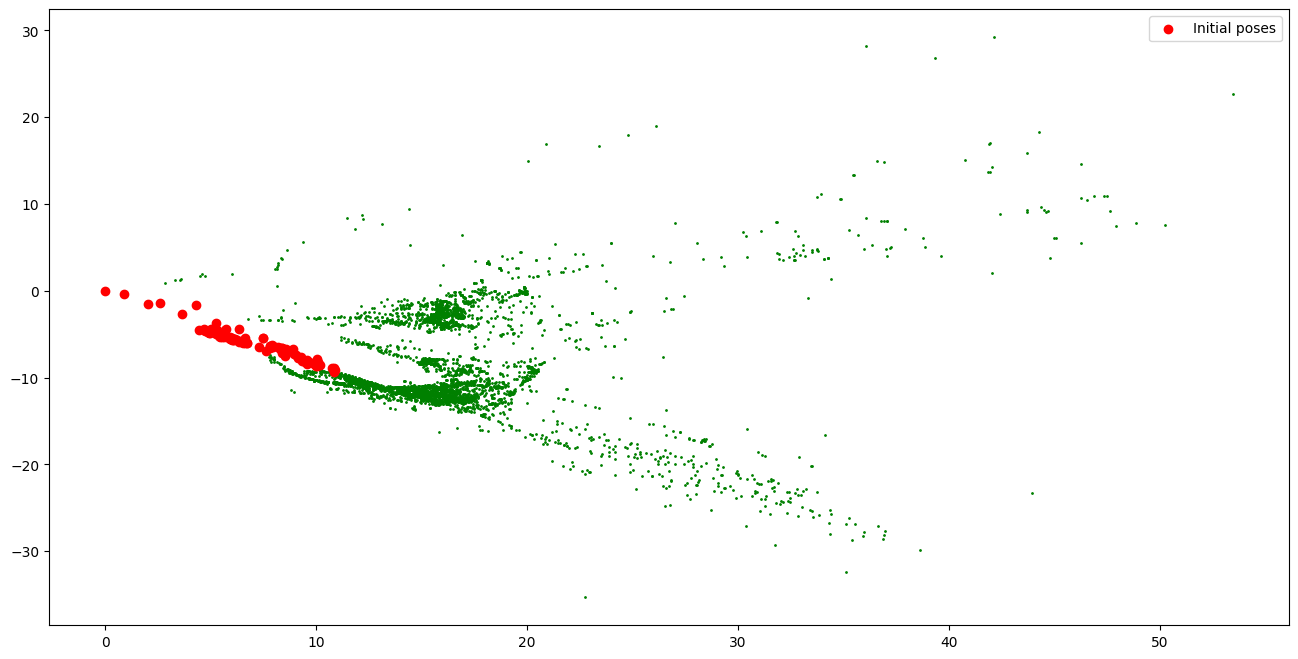

In [114]:
initial_poses = []
final_poses = []
for cam_sym in camera_ids:
  pose_initial = initial_values.atPose3(cam_sym)
  initial_poses.append((pose_initial.translation()[2], -pose_initial.translation()[0])) # OSS: z, -x in camera coordinates becomes x,y in world coordinates if the orientation of the camera is z = forward, x = right, y = downwards
initial_poses = np.array(initial_poses)

points = []
for point_sym in points_ids:
    point = initial_values.atPoint3(point_sym)
    points.append((point[2], -point[0]))
points = np.array(points)

# here we are plotting the original camera poses (pose_initial) and 3D points (point) before we optimize
plt.figure(figsize=(16,8))
plt.scatter(points[:, 0], points[:, 1], c='green', s=1)
plt.scatter(initial_poses[:, 0], initial_poses[:, 1], c='red', label='Initial poses')
plt.legend()

In [115]:
# Optimize
params = gtsam.LevenbergMarquardtParams()
params.setVerbosity("TERMINATION")   # "SILENT", "SUMMARY", "TERMINATION"
params.setVerbosityLM("TERMINATION")   # "SILENT", "SUMMARY", "TERMINATION"
params.setMaxIterations(100)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_values, params) # see theory
result = optimizer.optimize()
optimizer.print()

LevenbergMarquardtOptimizer
converged
errorThreshold: 2620923.90898 <? 0
absoluteDecrease: 0 <? 1e-05
relativeDecrease: 0 <? 1e-05
iterations: 63 >? 100
  parameters:

relative decrease threshold: 1e-05
absolute decrease threshold: 1e-05
      total error threshold: 0
         maximum iterations: 100
                  verbosity: TERMINATION
         linear solver type: MULTIFRONTAL CHOLESKY
                   ordering: COLAMD
              lambdaInitial: 1e-05
               lambdaFactor: 10
           lambdaUpperBound: 100000
           lambdaLowerBound: 0
           minModelFidelity: 0.001
            diagonalDamping: 0
                minDiagonal: 1e-06
                maxDiagonal: 1e+32
                verbosityLM: TERMINATION


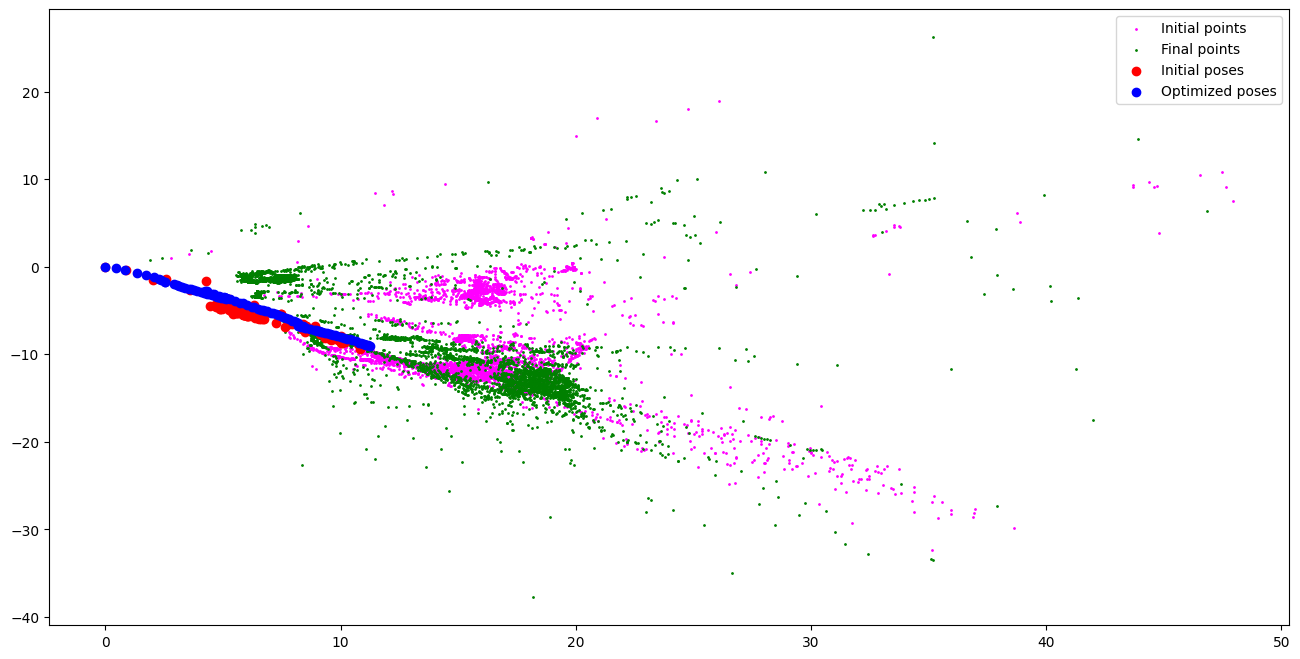

In [116]:
# Keep same scale factor of initial poses
scale = np.linalg.norm(initial_values.atPose3(camera_ids[-1]).translation()) / np.linalg.norm(result.atPose3(camera_ids[-1]).translation())
# explanation: the norm of the position of the last camera is the overall distance covered in a straight line, 
# we can compute the common scale scale factor as the ratio between the distance covered in the first experiement and the 
# distance covered in the result after optimization 

initial_poses = []
final_poses = []
for cam_sym in camera_ids:
  pose_initial = initial_values.atPose3(cam_sym)
  initial_poses.append((pose_initial.translation()[2], -pose_initial.translation()[0])) # same reason as before

  pose_final = result.atPose3(cam_sym)
  final_poses.append((scale*pose_final.translation()[2], -scale*pose_final.translation()[0]))

initial_poses = np.array(initial_poses)
final_poses = np.array(final_poses)


initial_points = []
points = []
for point_sym in points_ids:
    point_initial = initial_values.atPoint3(point_sym)
    point_final = result.atPoint3(point_sym)
    if np.linalg.norm(point_final) > 50/scale or point_final[2] < 0:
      continue
    initial_points.append((point_initial[2], -point_initial[0]))
    points.append((scale*point_final[2], -scale*point_final[0]))
initial_points = np.array(initial_points)
points = np.array(points)

plt.figure(figsize=(16,8))
plt.scatter(initial_points[:, 0], initial_points[:, 1], c='magenta', s=1, label='Initial points')
plt.scatter(points[:, 0], points[:, 1], c='green', s=1, label='Final points')
plt.scatter(initial_poses[:, 0], initial_poses[:, 1], c='red', label='Initial poses')
plt.scatter(final_poses[:, 0], final_poses[:, 1], c='blue', label='Optimized poses')
plt.legend()


In [117]:
# ts does not work

# def gtsam_result_to_open3d(result, pose_keys_prefix='c', point_keys_prefix='p'):
#     geometries = []

#     # --- Collect 3D points ---
#     pts = []
#     for key in result.keys():
#         ch = chr(gtsam.Symbol(key).chr())
#         if ch == point_keys_prefix:
#             pt = result.atPoint3(key)
#             if np.linalg.norm(pt) > 100/scale or pt[2] < 0:
#                 continue
#             pts.append([pt[0]*scale, pt[1]*scale, pt[2]*scale])
#     if pts:
#         pts_np = np.array(pts)
#         pcd = o3d.geometry.PointCloud()
#         pcd.points = o3d.utility.Vector3dVector(pts_np)
#         pcd.paint_uniform_color([0.1, 0.7, 0.1])  # green points
#         geometries.append(pcd)

#     # --- Collect camera poses as coordinate frames ---
#     for key in result.keys():
#         ch = chr(gtsam.Symbol(key).chr())
#         if ch == pose_keys_prefix:
#             pose = result.atPose3(key)
#             T = pose.matrix()
#             T[0:3, 3] *= scale
#             frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
#             frame.transform(T)   # apply pose transform
#             geometries.append(frame)

#     return geometries
# geometries = gtsam_result_to_open3d(result)
# o3d.visualization.draw_geometries(geometries, )
